In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Tiergarten

In [2]:
numNodes = Compute_Jacobian_Tiergarten.numNodes;
numLinks = Compute_Jacobian_Tiergarten.numLinks;
numODpairs = Compute_Jacobian_Tiergarten.numODpairs;
numZones = Compute_Jacobian_Tiergarten.numZones
od_pairs = Compute_Jacobian_Tiergarten.od_pairs;
link_list_js = Compute_Jacobian_Tiergarten.link_list_js;
link_length_list = Compute_Jacobian_Tiergarten.link_length_list;

In [3]:
require("prepare_data_Tiergarten.jl");
require("extract_data_Tiergarten.jl");
require("../Julia_files/tap_MSA.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");
require("../Julia_files/initia_data.jl");

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, 1];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Tiergarten_net.txt", tapFlowDicDict[0]);

In [7]:
arcsDict[0]

Dict{(Int64,Int64),Arc} with 766 entries:
  (248,65)  => Arc(248,65,900.0,17.0,494.57000000000005)
  (137,106) => Arc(137,106,2800.0,1.666667,223.97000000000003)
  (267,256) => Arc(267,256,2400.0,7.333333,86.95025999999999)
  (354,353) => Arc(354,353,900.0,1.0,416.9289400000001)
  (56,55)   => Arc(56,55,600.0,0.333333,0.0)
  (259,255) => Arc(259,255,2400.0,0.666667,0.0)
  (125,177) => Arc(125,177,900.0,1.666667,0.0)
  (36,35)   => Arc(36,35,2800.0,0.333333,19.65131999999999)
  (183,184) => Arc(183,184,900.0,0.333333,0.0)
  (43,361)  => Arc(43,361,2800.0,12.666667,6.5303799999999965)
  (16,277)  => Arc(16,277,999999.0,0.0,1556.2682200000004)
  (298,307) => Arc(298,307,2400.0,1.0,1529.7441999999994)
  (31,34)   => Arc(31,34,2800.0,0.666667,106.18041999999997)
  (187,191) => Arc(187,191,600.0,0.666667,228.4893)
  (241,244) => Arc(241,244,2400.0,0.333333,0.0)
  (84,95)   => Arc(84,95,900.0,2.333333,0.0)
  (221,2)   => Arc(221,2,999999.0,0.0,739.2046599999996)
  (23,351)  => Arc(23,351,9999

In [8]:
deg = 6
c = 0.5
lam = .001

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

INFO: Loading help data...


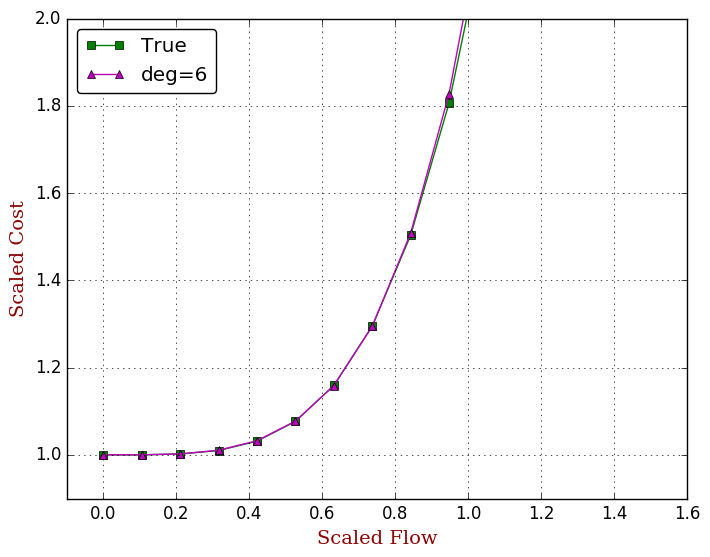

In [9]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

In [10]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [11]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Tiergarten_net.txt", tapFlowDicDict[1]);

In [12]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [13]:
linkCostDicDict[1]["0"], link_length_list[1]

(0.0,0.0)

In [14]:
jacobiSpiessDict[1] = Compute_Jacobian_Tiergarten.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [15]:
# maximum number of iterations
N = 100;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [16]:
for iterNumber = 1:N
    
    l = iterNumber;
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Tiergarten_net.txt", tapFlowDicDict[l+1]);
        
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Tiergarten.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
        
end

# normalize objective function value
for l = 1:(length(objFunDict))
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [17]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 7 entries:
  0 => [22.59,18.32,21.82,15.22,3.73,0.1,0.31,1.22,0.52,0.21,1.52,11.19,19.89,19…
  4 => [22.010135717980223,20.080756430773384,18.16174007866806,17.5178681541180…
  2 => [21.995771847990735,20.095674204850116,18.234252797293774,17.554518966255…
  3 => [21.998056641768972,20.093418079471746,18.21864006213391,17.5476336221983…
  5 => [22.01076885604326,20.07844254764861,18.15672445666273,17.514011857740567…
  6 => [22.01076885604326,20.07844254764861,18.15672445666273,17.514011857740567…
  1 => [21.920673817228206,20.050371076282058,18.284877770228423,17.506195019303…

In [18]:
norObjFunDict

Dict{Int64,Float64} with 6 entries:
  4 => 0.6712105918902672
  2 => 0.7966564203526453
  3 => 0.7546920681270455
  5 => 0.6540576243035293
  6 => 0.6540576243035293
  1 => 1.0

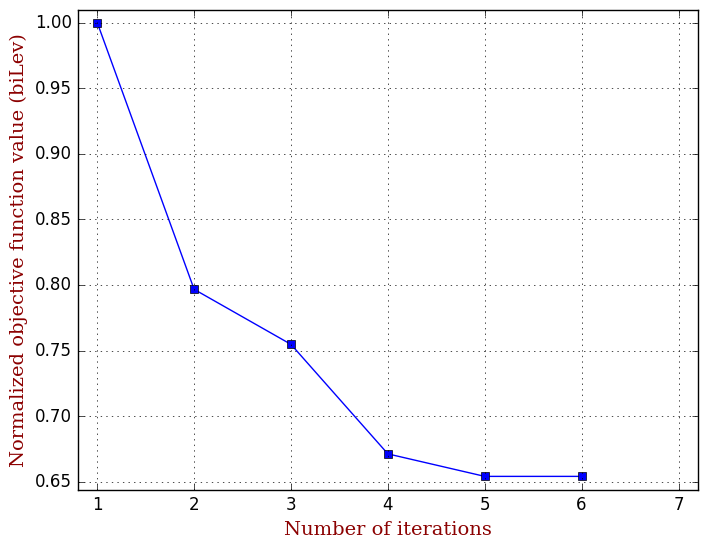

In [19]:
using PyPlot

iterNum = 1:(length(norObjFunDict))

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(norObjFunDict) + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Tiergarten.pdf")

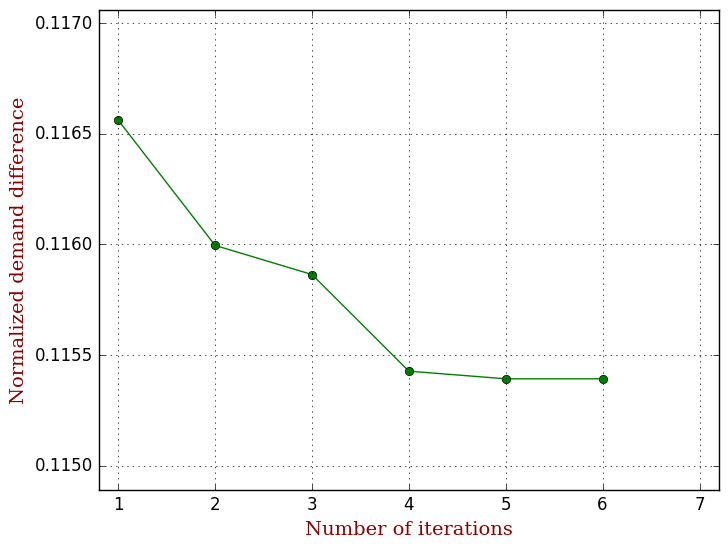

In [20]:
using PyPlot

iterNum = 1:(length(demandsDiffDict))

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(demandsDiffDict) + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Tiergarten.pdf")

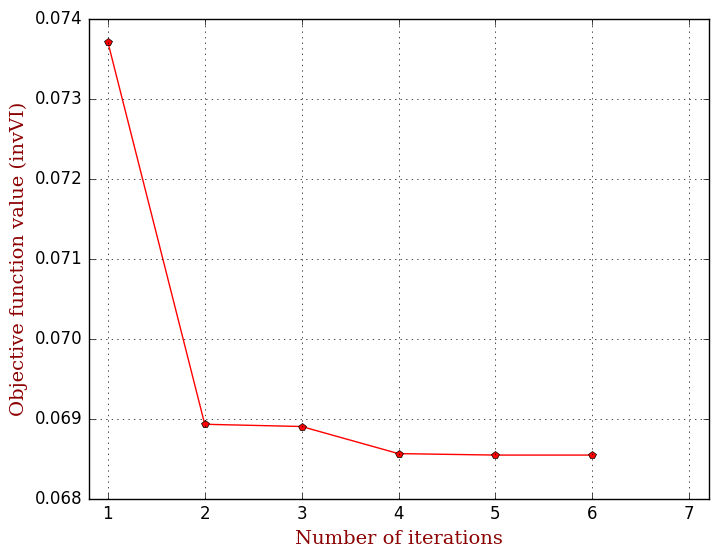

In [21]:
using PyPlot

iterNum = 1:(length(objInvVIDict))

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, length(objInvVIDict) + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Tiergarten.pdf")

In [22]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 6 entries:
  (6,0.5,0.001,3) => [1.0,0.0009038792940764483,-0.026307375557570876,0.23258177…
  (6,0.5,0.001,6) => [1.0,0.0008546885967363212,-0.02545290908263633,0.230684823…
  (6,0.5,0.001,4) => [1.0,0.0008572477081169993,-0.025497354525998335,0.23078364…
  (6,0.5,0.001,1) => [1.0,0.0011558619615481083,-0.030365634256517997,0.24151238…
  (6,0.5,0.001,5) => [1.0,0.0008546885967363212,-0.02545290908263633,0.230684823…
  (6,0.5,0.001,2) => [1.0,0.000904081012303722,-0.026309677383798573,0.232561375…

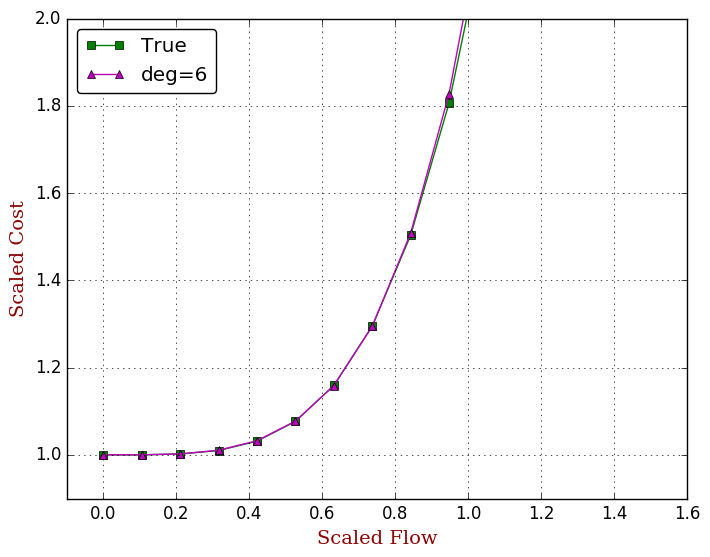

In [23]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

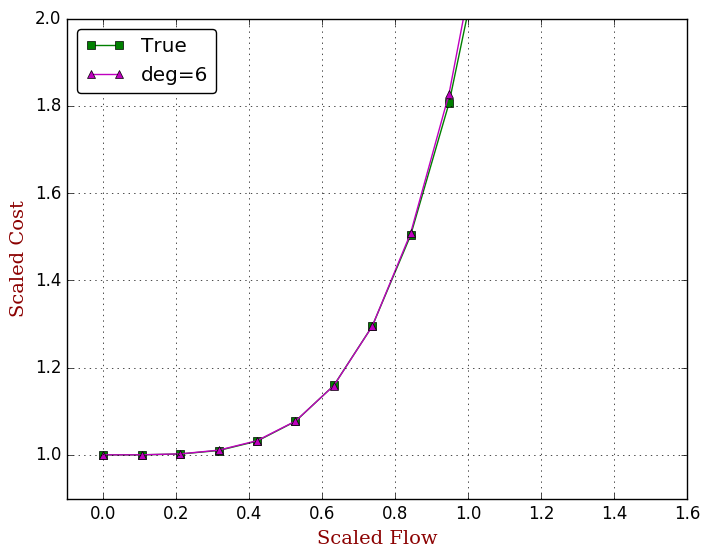

In [24]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

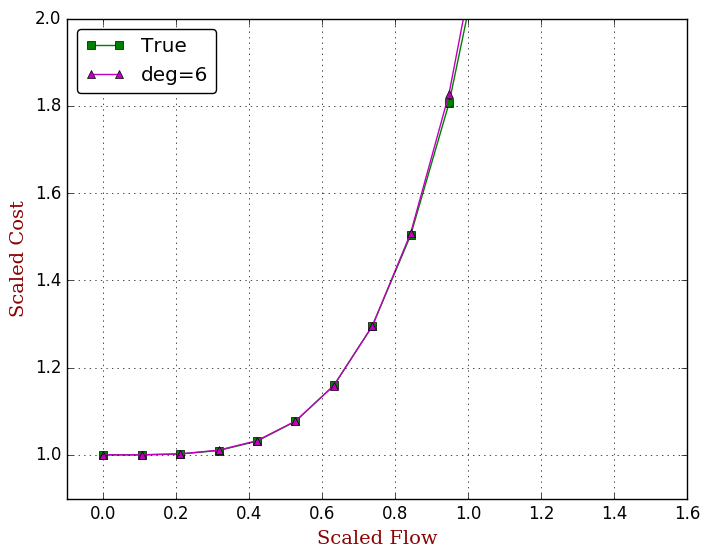

In [25]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

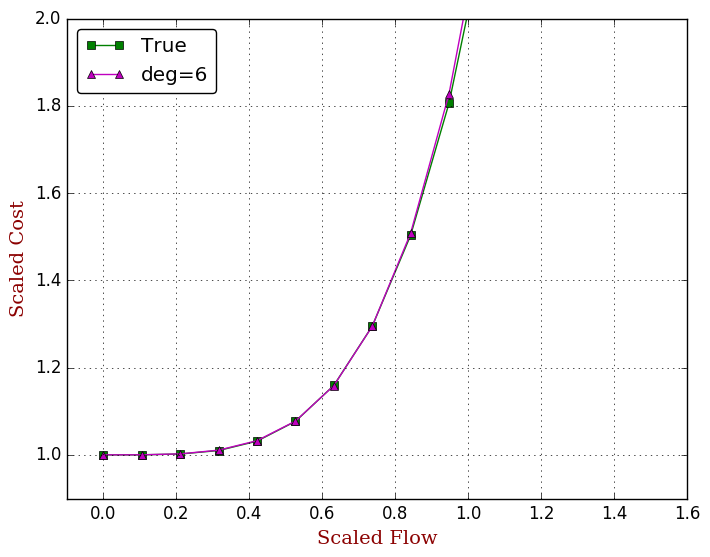

In [26]:
using PyPlot

iterN = length(coeffs_dict)

true_coeffs = [1, 0, 0, 0, 1]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(deg, c, lam, iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Tiergarten_iter_$(iterN).pdf")

In [27]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [28]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [29]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [30]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [31]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [32]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [33]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [34]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)